<a href="https://colab.research.google.com/github/JairEsc/Aproximaciones-de-Modelos-Epidemiologicos/blob/main/SIS_conteo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# SIS

In [2]:
def Monte_Carlo_Step_exp_mod(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación--
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network_SIS(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf,Tuto=False,hist_N_SI=[]):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    counter=0
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in G_network_initial.nodes():
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    if(hist_N_SI==[]):
      hist_N_SI=[[len(list(G_network_initial.neighbors(X_I_indexes[0]))),1]]
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(int(list(dict_num_contacts.keys())[-1])+1):#Podria no ser continuo? digamos k=0,1,2,5
            k=int(k)
            Lambdas.append((beta/N)*len(dict_num_contacts[str(k)])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp_mod(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            X_I+=1
            X_S-=1
            num_cont_inf_por_indice[new_reaction]=0#Una vez que se infecta, ignoramos momentaneamente el número de contactos infecciosos que tenía, pues ya no se puede volver a contagiar.
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo
            num_max_cont=int(list(dict_num_contacts.keys())[-1])

            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error. Pero ya está arreglado.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)# remove es con busqueda
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:# Paso de infeccioso a susceptible otra vez.
            X_I-=1
            X_S+=1
            G_network_initial.nodes[new_reaction]['Estado:']='Susceptible'
            #------------------ Volvemos a contar sus contactos infecciosos.
            num_cont_inf_por_indice[new_reaction]=0
            for neig in G_network_initial.neighbors(new_reaction):
                if(G_network_initial.nodes[neig]['Estado:']=='Infeccioso'):
                    num_cont_inf_por_indice[new_reaction]+=1
            #-------------------
            X_I_indexes.pop(new_reaction_index)#Lo saca de infecciosos
            #----------------- Lo volvemos a ubicar en susceptibles
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            if(num_cont_inf_por_indice[new_reaction]>num_max_cont):#Si mas de uno crea una categoria, hay error.
                for dif in range(num_max_cont+1,int(num_cont_inf_por_indice[new_reaction]+1)):
                    dict_num_contacts[str(dif)]=[]
                dict_num_contacts[str(int(num_cont_inf_por_indice[new_reaction]))]=[new_reaction]
            else:
                dict_num_contacts[str(int(num_cont_inf_por_indice[new_reaction]))].append(new_reaction)
            #-----------------
            i=new_reaction
            #print(i, "es el que se va a recuperar")
            #----------------- Actualizamos el numero de contactos de sus vecinos.
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                #print("estoy en el vecino ",vecino," con estatus: ",G_network_initial.nodes[vecino]['Estado:'])
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)#Actualizamos el numero de contactos infecciones en -1
                    #print("lo intento quitar del conjunto de ",num_cont_del_vecino, " vecinos infecciosos. i.e.", dict_num_contacts[str(int(num_cont_del_vecino))])
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion

            #-------------------------------------------
        t+=tau #Actualiza el tiempo
        if Tuto:
            print("Se genera el tiempo ",tau)
            print("Se selecciona al individuo",i)
            print("infectado por estar en el grupo con ", k_choice)
            nx.draw(G=G_network_initial,node_color=['green' if G_network_initial.nodes[i]['Estado:']=='Susceptible' else 'red' if G_network_initial.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in G.nodes()],with_labels=True)
            plt.show()
        X_I=len(X_I_indexes)
        X_S=N-X_I
        N_SI=int(np.sum(num_cont_inf_por_indice))
        hist_N_SI.append([N_SI,X_I])
        Historia.append([t,X_S,X_I])#Focus
        counter+=1
        if(X_I==0 or len(Historia)==T):
            flag=False
    return Historia,hist_N_SI

# Exploración del número de aristas promedio vs. la aproximación asumiendo uniformidad de la distribución de infecciosos sobre la gráfica

$$N_{SI}(k)=k\frac{N-k}{N}n$$
y
$$\hat{N}_{SI}(k)=k(N-k)p$$


### Caso 1 Usando G(N,p), $p= 0.1$, N=21. Debería ser parecida a una 2-regular.

In [3]:
N=21
min_len_col=0
hist_N_SI=[]
np.random.seed(0)
iteraciones=1000
iter=0
conteo_data=pd.DataFrame([[0,0]],columns=['N_SI','k'])
while(iter<iteraciones):
  iter+=1
  G=nx.gnp_random_graph(n=N,p=0.1)
  G=nx.convert_node_labels_to_integers(G,ordering='default',)
  while(nx.is_connected(G)==False):#Generar una gráfica conexa
      G=nx.gnp_random_graph(n=N,p=0.1)
      G=nx.convert_node_labels_to_integers(G,ordering='default',)
  X_I_indexes=[0]
  for k in range(N):
      if k in X_I_indexes:
          G.nodes[k]['Estado:']='Infeccioso'
      else:
          G.nodes[k]['Estado:']='Susceptible'
  G_copy=G.copy()
  H,hist_N_SI=Gillespie_Direct_Method_Network_SIS(beta=1.15*N,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=10**3,Tuto=False,hist_N_SI=hist_N_SI)
  conteo_data=pd.DataFrame(hist_N_SI,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
print(conteo_promedio)

         N_SI
k            
0    0.000000
1    2.624691
2    4.122457
3    5.517544
4    6.798435
5    7.994011
6    9.046733
7    9.985462
8   10.738320
9   11.265218
10  11.588971
11  11.676326
12  11.509460
13  11.155827
14  10.586568
15   9.798176
16   8.754924
17   7.479479
18   5.966254
19   4.203731
20   2.214286
21   0.000000


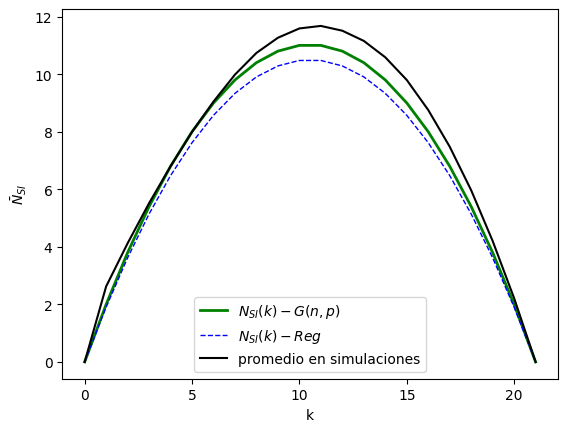

In [4]:
conteo_promedio=conteo_data.groupby(['k']).mean()
n=2
r=[]
r2=[]
for i in range(0,len(conteo_promedio)):
    r.append(i*((N-i)/N)*(0.1*(N-1)))
    r2.append(i*(N-i)*0.1)
conteo_promedio['reg']=r
conteo_promedio['gnp']=r2
plt.plot(conteo_promedio['gnp'],color='g',linewidth=2,label=r'$N_{SI}(k)-G(n,p)$')
plt.plot(conteo_promedio['reg'],color='b',linestyle='dashed',linewidth=1,label=r'$N_{SI}(k)-Reg$')
plt.plot(conteo_promedio.N_SI,color='black',label='promedio en simulaciones')
plt.legend()
plt.xlabel('k')
plt.ylabel(r'$\bar{N}_{SI}$')
plt.savefig('SIS_edges_a.png',dpi=300)
plt.show()

### Caso 2. $r-$Regular $N=21$, $r=2$.

In [5]:
N=21
min_len_col=0
hist_N_SI=[]
np.random.seed(1)
iteraciones=1000
iter=0
conteo_data=pd.DataFrame([[0,0]],columns=['N_SI','k'])
while(iter<iteraciones):
  iter+=1
  G=nx.random_regular_graph(d=2,n=N)
  G=nx.convert_node_labels_to_integers(G,ordering='default',)
  while(nx.is_connected(G)==False):#Asegurarme que salga una gráfica conexa
      N=21
      n=2
      G=nx.random_regular_graph(d=n,n=N)
      G=nx.convert_node_labels_to_integers(G,ordering='default',)
  X_I_indexes=[0]
  for k in range(N):
      if k in X_I_indexes:
          G.nodes[k]['Estado:']='Infeccioso'
      else:
          G.nodes[k]['Estado:']='Susceptible'
  G_copy=G.copy()
  H,hist_N_SI=Gillespie_Direct_Method_Network_SIS(beta=1.15*N,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=10**3,Tuto=False,hist_N_SI=hist_N_SI)
  conteo_data=pd.DataFrame(hist_N_SI,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
print(conteo_promedio)

        N_SI
k           
0   0.000000
1   2.000000
2   2.559300
3   3.081870
4   3.620532
5   4.103137
6   4.535694
7   5.002417
8   5.422640
9   5.730203
10  6.207509
11  6.639344
12  7.005059
13  7.229462
14  7.104762
15  6.803922
16  6.333333
17  7.777778
18  6.000000
19  4.000000


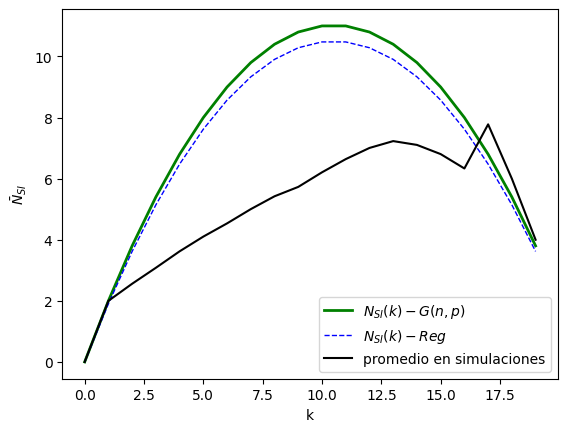

In [6]:
conteo_promedio=conteo_data.groupby(['k']).mean()
n=2
r=[]
r2=[]
for i in range(0,len(conteo_promedio)):
    r.append(i*((N-i)/N)*(0.1*(N-1)))
    r2.append(i*(N-i)*0.1)
conteo_promedio['reg']=r
conteo_promedio['gnp']=r2
plt.plot(conteo_promedio['gnp'],color='g',linewidth=2,label=r'$N_{SI}(k)-G(n,p)$')
plt.plot(conteo_promedio['reg'],color='b',linestyle='dashed',linewidth=1,label=r'$N_{SI}(k)-Reg$')
plt.plot(conteo_promedio.N_SI,color='black',label='promedio en simulaciones')
plt.legend()
plt.xlabel('k')
plt.ylabel(r'$\bar{N}_{SI}$')
plt.savefig('SIS_edges_b.png',dpi=300)
plt.show()

In [7]:
N=10**3
min_len_col=0
hist_N_SI=[]
np.random.seed(0)
iteraciones=100
iter=0
conteo_data=pd.DataFrame([[0,0]],columns=['N_SI','k'])
while(iter<iteraciones):
  iter+=1
  G=nx.gnp_random_graph(n=N,p=0.1)
  G=nx.convert_node_labels_to_integers(G,ordering='default',)
  while(nx.is_connected(G)==False):#Generar una gráfica conexa
      G=nx.gnp_random_graph(n=N,p=0.1)
      G=nx.convert_node_labels_to_integers(G,ordering='default',)
  X_I_indexes=[0]
  for k in range(N):
      if k in X_I_indexes:
          G.nodes[k]['Estado:']='Infeccioso'
      else:
          G.nodes[k]['Estado:']='Susceptible'
  G_copy=G.copy()
  H,hist_N_SI=Gillespie_Direct_Method_Network_SIS(beta=1.15*N,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=10**3,Tuto=False,hist_N_SI=hist_N_SI)
  conteo_data=pd.DataFrame(hist_N_SI,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
print(conteo_promedio)

            N_SI
k               
0       0.000000
1      98.000000
2     198.574257
3     295.883495
4     393.757282
..           ...
961  3661.000000
962  3559.666667
963  3467.333333
964  3359.000000
965  3213.000000

[966 rows x 1 columns]


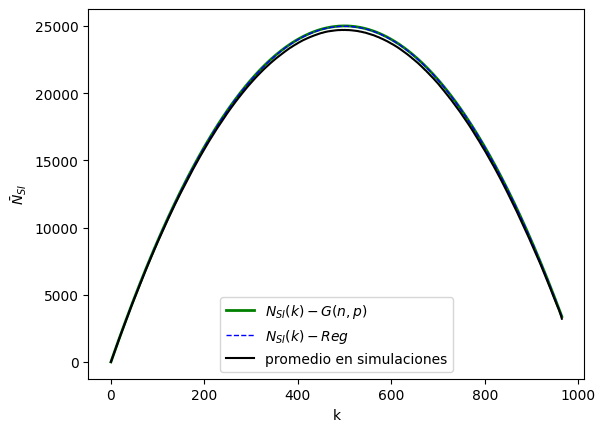

In [8]:
conteo_promedio=conteo_data.groupby(['k']).mean()
n=2
r=[]
r2=[]
for i in range(0,len(conteo_promedio)):
    r.append(i*((N-i)/N)*(0.1*(N-1)))
    r2.append(i*(N-i)*0.1)
conteo_promedio['reg']=r
conteo_promedio['gnp']=r2
plt.plot(conteo_promedio['gnp'],color='g',linewidth=2,label=r'$N_{SI}(k)-G(n,p)$')
plt.plot(conteo_promedio['reg'],color='b',linestyle='dashed',linewidth=1,label=r'$N_{SI}(k)-Reg$')
plt.plot(conteo_promedio.N_SI,color='black',label='promedio en simulaciones')
plt.legend()
plt.xlabel('k')
plt.ylabel(r'$\bar{N}_{SI}$')
plt.savefig('SIS_edges_c.png',dpi=300)
plt.show()

Reg

In [9]:
N=10**3
min_len_col=0
hist_N_SI=[]
np.random.seed(1)
iteraciones=100
iter=0
conteo_data=pd.DataFrame([[0,0]],columns=['N_SI','k'])
while(iter<iteraciones):
  iter+=1
  G=nx.random_regular_graph(d=100,n=N)
  G=nx.convert_node_labels_to_integers(G,ordering='default',)
  while(nx.is_connected(G)==False):#Asegurarme que salga una gráfica conexa
      N=21
      n=2
      G=nx.random_regular_graph(d=n,n=N)
      G=nx.convert_node_labels_to_integers(G,ordering='default',)
  X_I_indexes=[0]
  for k in range(N):
      if k in X_I_indexes:
          G.nodes[k]['Estado:']='Infeccioso'
      else:
          G.nodes[k]['Estado:']='Susceptible'
  G_copy=G.copy()
  H,hist_N_SI=Gillespie_Direct_Method_Network_SIS(beta=1.15*N,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=10**3,Tuto=False,hist_N_SI=hist_N_SI)
  conteo_data=pd.DataFrame(hist_N_SI,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
print(conteo_promedio)

            N_SI
k               
1     100.000000
2     198.056604
3     295.884615
4     393.564356
5     491.049505
..           ...
963  3569.600000
964  3472.000000
965  3376.000000
966  3280.000000
967  3186.000000

[967 rows x 1 columns]


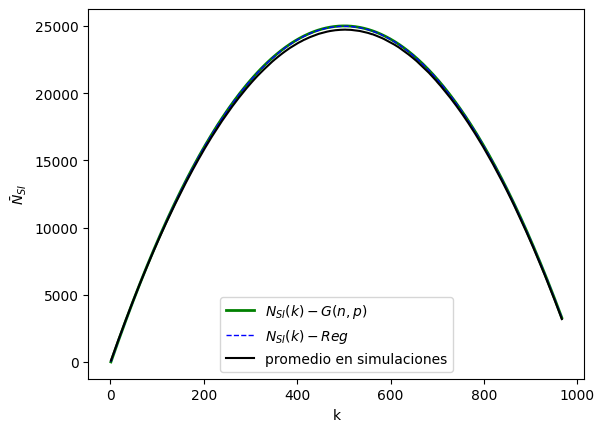

In [10]:
conteo_promedio=conteo_data.groupby(['k']).mean()
n=2
r=[]
r2=[]
for i in range(0,len(conteo_promedio)):
    r.append(i*((N-i)/N)*(0.1*(N-1)))
    r2.append(i*(N-i)*0.1)
conteo_promedio['reg']=r
conteo_promedio['gnp']=r2
plt.plot(conteo_promedio['gnp'],color='g',linewidth=2,label=r'$N_{SI}(k)-G(n,p)$')
plt.plot(conteo_promedio['reg'],color='b',linestyle='dashed',linewidth=1,label=r'$N_{SI}(k)-Reg$')
plt.plot(conteo_promedio.N_SI,color='black',label='promedio en simulaciones')
plt.legend()
plt.xlabel('k')
plt.ylabel(r'$\bar{N}_{SI}$')
plt.savefig('SIS_edges_d.png',dpi=300)
plt.show()